# Mnist classifier using Gradient Descent and Newton method
### we sill use logistic regression to classify 8&9 and 0&1 digits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from mlxtend.data import loadlocal_mnist
from sklearn.preprocessing import MinMaxScaler

### example of using the sigmoid function

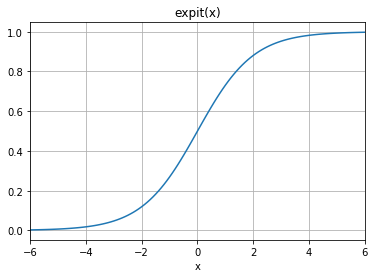

In [2]:
x = np.linspace(-6, 6, 121)
y = expit(x)
plt.plot(x, y)
plt.grid()
plt.xlim(-6, 6)
plt.xlabel('x')
plt.title('expit(x)')
plt.show()



## Loading the data, and filtering only 8&9 digitis with with corresponding labels of 0/1

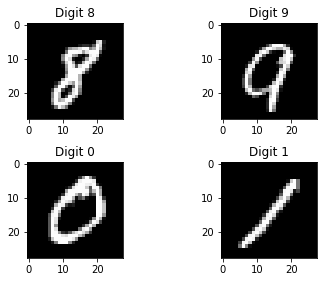

Dimensions: 5878 x 784
Digits: 8 9
labels: [0 1]
[0 0 0 ... 1 1 1]
Class distribution: [2875 3003]


In [3]:
def filter(images, labels, digit_c1, digit_c2):
    '''
    :param images:
    :param labels:
    :return: filted images and labels , images will have only 8/9 images,
             with corresponding labels of 0/1
    '''
    index_of_c1 = []
    index_of_c2 = []
    for index, label in enumerate(labels):
        if label == digit_c1:
            index_of_c1.append(index)
        elif label == digit_c2:
            index_of_c2.append(index)
    join_eight_nine_list = [*index_of_c1, *index_of_c2]
    images = np.take(images, join_eight_nine_list, axis=0)
    labels = np.take(labels, join_eight_nine_list, axis=0)
    labels = np.array([0 if label == digit_c1 else 1 for label in labels])
    return (images, labels)


train_x, train_y = loadlocal_mnist(
    images_path='/home/maor/Desktop/MMA202/section4/code/data/train-images.idx3-ubyte',
    labels_path='/home/maor/Desktop/MMA202/section4/code/data/train-labels.idx1-ubyte')
train_x = train_x[:30000]
train_y = train_y[:30000]
train_x_8_9, train_y_8_9 = filter(train_x, train_y, 8, 9)
train_x_0_1, train_y_0_1 = filter(train_x, train_y, 0, 1)

test_x, test_y = loadlocal_mnist(
    images_path='/home/maor/Desktop/MMA202/section4/code/data/t10k-images.idx3-ubyte',
    labels_path='/home/maor/Desktop/MMA202/section4/code/data/t10k-labels.idx1-ubyte')
test_x = test_x[:3000]
test_y = test_y[:3000]
test_x_8_9, test_y_8_9 = filter(test_x, test_y, 8, 9)
test_x_0_1, test_y_0_1 = filter(test_x, test_y, 0, 1)

scaler = MinMaxScaler()

digit_8 = train_x_8_9[0].reshape((28, 28))
digit_9 = train_x_8_9[-1].reshape((28, 28))
digit_0 = train_x_0_1[0].reshape((28, 28))
digit_1 = train_x_0_1[-1].reshape((28, 28))
plt.subplot(221, title='Digit 8')
plt.imshow(digit_8, cmap='gray');
plt.subplot(222, title='Digit 9')
plt.imshow(digit_9, cmap='gray');
plt.subplot(223, title='Digit 0')
plt.imshow(digit_0, cmap='gray');
plt.subplot(224, title='Digit 1')
plt.imshow(digit_1, cmap='gray');
plt.tight_layout(1)
plt.show()

print('Dimensions: %s x %s' % (train_x_8_9.shape[0], train_x_8_9.shape[1]))
print('Digits: 8 9')
print('labels: %s' % np.unique(train_y_8_9))
print(train_y_8_9)
print('Class distribution: %s' % np.bincount(train_y_8_9))

### The functions we will be using

In [4]:
def data_init(X, y):
    '''

    :param X:train_x
    :param y:train_y - labels
    :return: add a ones to each row of train_x
                create zeros weights called params
                make the laable a matrix insted of just list.
    '''
    y = y[:, np.newaxis]
    m = len(y)
    X = np.hstack((np.ones((m, 1)), X))
    n = np.size(X, 1)
    # params = np.random.rand(n,1)
    params = np.zeros((n, 1))
    return (X, y, params)


def sigmoid(x):
    return expit(x)


def predict(features, weights):
    z = np.dot(features, weights)
    return expit(z)


def cost_function(features, labels, weights):
    observations = len(labels)
    predictions = predict(features, weights)
    # Take the error when label=1
    class1_cost = -labels * np.log(predictions)
    # Take the error when label=0
    class2_cost = (1 - labels) * np.log(1 - predictions)
    # Take the sum of both costs
    cost = class1_cost - class2_cost
    # Take the average cost
    cost = cost.sum() / observations
    return cost


def gradient_descent(features, labels, weights, lr):
    N = len(features)
    predictions = predict(features, weights)
    gradient = np.dot(features.T, predictions - labels)
    gradient /= N
    gradient *= lr
    weights -= gradient
    return weights

# we will use this function in newton method
def gradient(features, labels, weights, lr):
    N = len(features)
    predictions = predict(features, weights)
    gradient = np.dot(features.T, predictions - labels)
    gradient /= N
    gradient *= lr
    return gradient

def trainGD(features, labels, weights, lr, iters):
    cost_history = []
    for i in range(iters):
        weights = gradient_descent(features, labels, weights, lr)
        # Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)
        # if i != 0 and abs(cost_history[i] - cost_history[i - 1]) < 1e-4:
        #     break;
        # Log Progress
        if i % 1000 == 0:
            print("iter: " + str(i) + " cost: " + str(cost))

    return cost_history, weights

def hessian(features, weights):
    M = len(features)
    predictions = predict(features, weights)
    D = np.diag(np.diag(np.dot(predictions, (1 - predictions).T)))
    result = (1 / M) * np.dot(features.T, np.dot(D, features))
    return result


def newton(features, labels, weights, lr):
    h = hessian(features, weights)
    inv_h = np.linalg.inv(h + np.eye(h.shape[0]) * 0.3)
    grad = gradient(features, labels, weights, lr)
    d = (-1) * np.dot(np.linalg.inv(h + np.eye(h.shape[0]) * 0.3), gradient(features, labels, weights, lr))
    weights = weights + (0.2 * d)
    return weights


def train_Newton(features, labels, weights, lr, iters):
    cost_history = []
    for i in range(iters):
        weights = newton(features, labels, weights, lr)
        # Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)
        # if i != 0 and abs(cost_history[i] - cost_history[i - 1]) < 1e-4:
        #     break;
        # Log Progress
        if i % 1000 == 0:
            print("iter: " + str(i) + " cost: " + str(cost))

    return cost_history, weights

## Training the program
we will use several learning rates, i.e. lr, including lr=1,0,3,0.2,0.1

iter: 0 cost: 0.2921735259419504
iter: 0 cost: 0.034579559863731214
iter: 0 cost: 0.032226122118063645
iter: 0 cost: 0.03097955174601086


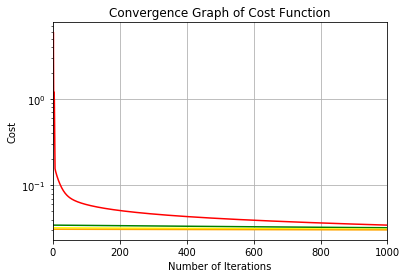

In [5]:
(X, y, params) = data_init(train_x_8_9, train_y_8_9)
scaler = MinMaxScaler()
#
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)
params = scaler.fit_transform(params)
lr_list = [1, 0.3, 0.2, 0.1]
c_list = ['red', 'green', 'yellow', 'orange']

for lr, color in zip(lr_list, c_list):
    (cost_history, params_optimal) = trainGD(X, y, params, lr, 1000)
    plt.plot(range(len(cost_history)), cost_history, c=color);
# (cost_history, params_optimal) = train(X, y, params, 1, 100)
# plt.plot(range(len(cost_history)), cost_history, c='red')
plt.yscale('log')
x = np.linspace(0, 1000, 101)
plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.xlim(0, 1000)
plt.grid()
plt.ylabel("Cost")
plt.show()


### now we will evaluate our GD program, using only 100 iterations we get high accuracy on the data


In [6]:
def accuracy(predicted_labels, actual_labels):
    diff = predicted_labels - actual_labels
    return 1.0 - (float(np.count_nonzero(diff)) / len(diff))


def classify(predictions):
    '''
    input  - N element array of predictions between 0 and 1
    output - N element array of 0s (False) and 1s (True)
    '''
    predictions = [1 if pred > 0.5 else 0 for pred in predictions]
    return predictions


def evaluate(train_X, train_y, test_X, test_y, learning_rate):
    (X, y, params) = data_init(train_X, train_y)
    X = scaler.fit_transform(X)
    (_, params_optimal_1) = trainGD(X, y, params, learning_rate, 100)
    X_test = np.hstack((np.ones((test_X.shape[0], 1)), test_X))
    X_test = scaler.fit_transform(X_test)
    y_pred_train = predict(X, params_optimal_1)
    y_pred_train = classify(y_pred_train)
    train_score = accuracy(y_pred_train, train_y)
    print('Training Score:', train_score)
    y_pred_test = predict(X_test, params_optimal_1)
    y_pred_test = classify(y_pred_test)
    test_score = accuracy(y_pred_test, test_y)
    print('Test Score:', test_score)


print('Evaluation results for 8 and 9 digits:')
print('-' * 50)
evaluate(train_x_8_9, train_y_8_9, test_x_8_9, test_y_8_9, 1)
print('\n\nEvaluation results for 0 and 1 digits:')
print('-' * 50)
evaluate(train_x_0_1, train_y_0_1, test_x_0_1, test_y_0_1, 1)




Evaluation results for 8 and 9 digits:
--------------------------------------------------
iter: 0 cost: 0.2921735259419504
Training Score: 0.9797550187138483
Test Score: 0.9569707401032702


Evaluation results for 0 and 1 digits:
--------------------------------------------------
iter: 0 cost: 0.05379208762436325
Training Score: 0.9981203007518797
Test Score: 1.0


### Now we will do the same with Newton method using 12 iterations

iter: 0 cost: 0.030422179838893986
iter: 0 cost: 0.03042467087346299
iter: 0 cost: 0.030425026769123592
iter: 0 cost: 0.030425382673179555


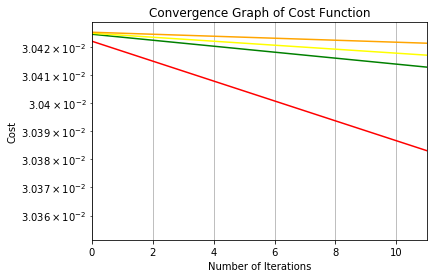

In [7]:
lr_list = [1, 0.3, 0.2, 0.1]
c_list = ['red', 'green', 'yellow', 'orange']

for lr, color in zip(lr_list, c_list):
    (cost_history, params_optimal) = train_Newton(X, y, params, lr, 20)
    plt.plot(range(len(cost_history)), cost_history, c=color)
# (cost_history, params_optimal) = train(X, y, params, 1, 70)
# plt.plot(range(len(cost_history)), cost_history, c='red')
plt.yscale('log')
x = np.linspace(0, 10, 11)
plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.xlim(0, 11)
plt.grid()
plt.ylabel("Cost")
plt.show()


In [8]:
def evaluate(train_X, train_y, test_X, test_y, learning_rate):
    (X, y, params) = data_init(train_X, train_y)
    X = scaler.fit_transform(X)
    (_, params_optimal_1) = train_Newton(X, y, params, learning_rate, 12)
    X_test = np.hstack((np.ones((test_X.shape[0], 1)), test_X))
    X_test = scaler.fit_transform(X_test)
    y_pred_train = predict(X, params_optimal_1)
    y_pred_train = classify(y_pred_train)
    train_score = accuracy(y_pred_train, train_y)
    print('Training Score:', train_score)
    y_pred_test = predict(X_test, params_optimal_1)
    y_pred_test = classify(y_pred_test)
    test_score = accuracy(y_pred_test, test_y)
    print('Test Score:', test_score)


print('Evaluation results for 8 and 9 digits:')
print('-' * 50)
evaluate(train_x_8_9, train_y_8_9, test_x_8_9, test_y_8_9, 1)
print('Evaluation results for 0 and 1 digits:')
print('-' * 50)
evaluate(train_x_0_1, train_y_0_1, test_x_0_1, test_y_0_1, 1)

Evaluation results for 8 and 9 digits:
--------------------------------------------------
iter: 0 cost: 0.5798044024298091
Training Score: 0.9644436883293638
Test Score: 0.9466437177280551
Evaluation results for 0 and 1 digits:
--------------------------------------------------
iter: 0 cost: 0.5386350732693072
Training Score: 0.9974937343358397
Test Score: 1.0
